**Variational Autoencoder**

The variational autoencoder implemented uses a similar setup found in most VAE papers; a multivariate normal distribution for the conditional distribution of the latent vectors given and the input image q_θ (z| x_i) and a multivariate Bernoulli distribution for the conditional distribution of images given the latent vector p_ϕ (x | z). Using a Bernoulli distribution, the negative log likelihood of a data points the distribution i.e., the reconstruction loss reduces to the pixel wise binary cross entropy.


In [1]:
# Click runtime -> change runtime type -> set to GPU
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

**Setting Parameters**


In [2]:
# Two dimensionallatent space, parameter count in same order of magnitude
latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

**Loading MNIST Dataset**

The MNIST images consists of digits 0-9 in a 28*28 grayscale images. 
We do not center them as we will be using a binary cross entropy loss that treats pixel values as probabilities in [0,1] while creating the training and test data sets.


In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw




Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**Defining Variational Autoencoder Module**

Both the encoder and decoder neural networks consist of two hidden convolutional layers. Convolution layers have been used as they general give better performance than fully connected versions that have the same number of parameters. Each of the convolutional layers in the encoder and the first convolutional layer in the decoder are using ReLu activations, while the final convolutional layer of the decoder has a sigmoid activation since binary cross entropy for the computation of the reconstruction loss.
During the reconstruction of the image from the latent space, the network general builds them up from low resolution, high-level descriptions, i.e., the network describe a rough image and then fills in the details. This process is generally occurring during the deconvolution process in the decoder. However, the deconvolution process can lead to uneven overlap when the kernel size (output window size) is not visible to the stride of deconvolution filter (spacing between points on the top), causing checkerboard effect (https://distill.pub/2016/deconv-checkerboard/) in the decoded image. In order to diminish this effect, the kernel size has been set to 4.



In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = x.view(x.size(0), -1) 
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = x.view(x.size(0), capacity*2, 7, 7) 
        x = F.relu(self.conv2(x))
        # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        x = torch.sigmoid(self.conv1(x)) 
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
  # '''
  # - > recon_x is the probability of a multivariate Bernoulli distribution p.
  # -> -log(p(x)) is then the pixel-wise binary cross-entropy.
  # '''
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
  # '''
  #   KL-divergence between the prior distribution over latent vectors and the distribution estimated by the generator for the given image.
  # '''  
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


**Training VAE** 

1.	An input image is passed through the encoder.
2.	The encoder outputs the parameters of the distribution.
3.	A latent space z is sampled from the output of the encoder output.
4.	The decoder then decodes the latent space to reconstruct the image.
5.	Reconstruction error is computed using over various datapoints using binary cross entropy loss and the KL divergence functions.
6.	Finally, perform backpropagation and an optimization step to update the network parameters of both the decoder and encoder.

In [6]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 23994.265606
Epoch [2 / 100] average reconstruction error: 21460.332017
Epoch [3 / 100] average reconstruction error: 20772.565859
Epoch [4 / 100] average reconstruction error: 20396.336058
Epoch [5 / 100] average reconstruction error: 20177.223624
Epoch [6 / 100] average reconstruction error: 20029.847952
Epoch [7 / 100] average reconstruction error: 19928.135482
Epoch [8 / 100] average reconstruction error: 19840.432563
Epoch [9 / 100] average reconstruction error: 19771.485499
Epoch [10 / 100] average reconstruction error: 19711.563341
Epoch [11 / 100] average reconstruction error: 19640.625458
Epoch [12 / 100] average reconstruction error: 19601.139871
Epoch [13 / 100] average reconstruction error: 19554.136975
Epoch [14 / 100] average reconstruction error: 19521.885076
Epoch [15 / 100] average reconstruction error: 19475.102883
Epoch [16 / 100] average reconstruction error: 19443.033341
Epoch [17 / 100] average reconstruct

**Training Curve Plot**

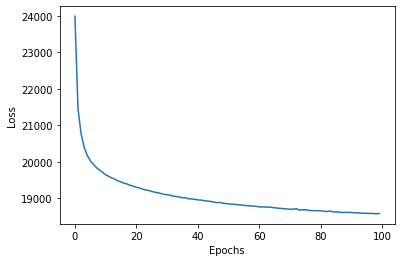

In [7]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

**Evaluation on Training Set**

In [8]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 19313.508344


**Visualizing the reconstructued images**

Original images


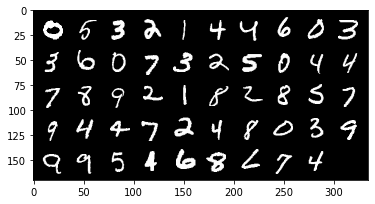

VAE reconstruction:


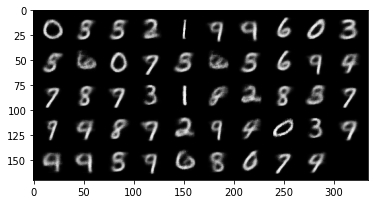

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

**Latent Space Interpolation**

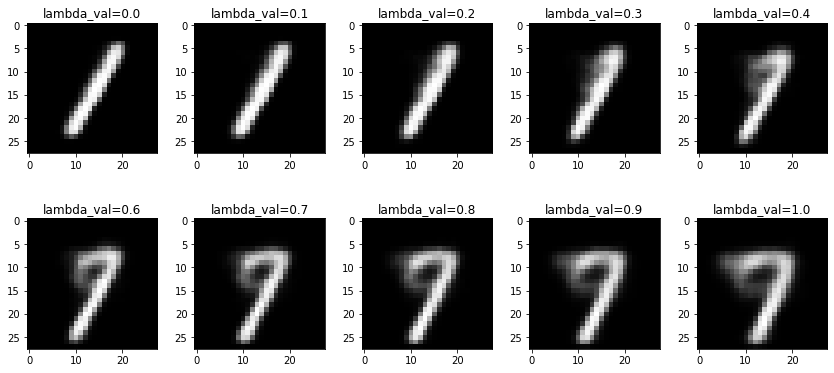

In [10]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 